# Generative adversarial network
In this notebook, a generative adversarial network is used to try to make a converter of images from the highly accessible bright field microscopy images to the more qualitative dark field images. Contrary to a purely generative network, we will try to use the full information of the previous image by using style transfer. This method, if shown effective, could also be generalized to other kind of microscopy, like phase contrast.
To have as good a result as possible, an adversarial loss will be tried

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import random
import sys
import time
import pickle
import importlib

from scipy import ndimage
#NN package
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras import utils

from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as K

In [65]:
def discriminator(layer_in,dropout=0.8,depth=5,n_channels=3):
    #network trained to decide if an image is coming from a modified bright field picture or an original
    #dark field one
    for i in range(depth):
        conv = layers.Conv2D(n_channels,3,padding = 'same')(layer_in)
        maxp = layers.MaxPooling2D()(conv)
        layer_in = maxp
    flat = layers.Flatten()(layer_in)
    densein = layers.Dense(32,activation='relu')(flat)
    drop = layers.Dropout(dropout)(densein)
    denseout = layers.Dense(1,activation = 'sigmoid')(drop)
    return denseout
size = 64
visible = layers.Input(shape = (size,size,3),name='image')
loss = discriminator(visible)
discriminator_net = Model(inputs = visible,outputs = loss,name = 'discriminator')

In [66]:
VGG19 = tf.keras.applications.VGG19(include_top=False,
                                    weights=None,
                                    input_shape=(size,size,3))
VGG19.load_weights('Model_weights/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
Encoder_ml = Model(inputs=VGG19.input, outputs=[
                                            VGG19.get_layer('block1_conv2').output,
                                            VGG19.get_layer('block2_conv2').output,
                                            VGG19.get_layer('block3_conv4').output,
                                            VGG19.get_layer('block4_conv1').output]
                ,name='encoder',trainable=False)
Encoder_ml.save_weights('Model_weights/encoder_pretrained_from_VGG19.h5')

Encoder_ml.summary()
#now that the pretrained weights are know, it is needed to redefine theses layer manually to obtain reflect padding


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [67]:
#define a custom padding layer to use reflect padding
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
#define a custom convolution layer
class ReflectionConv2D(Layer):
    def __init__(self,filters, kernel,**kwargs):
        super().__init__(**kwargs)
        self.pad = ReflectionPadding2D()
        self.conv = layers.Conv2D(filters,kernel,padding='valid',activation='elu')
    def call(self,inputs):
        padded = self.pad(inputs)
        out = self.conv(padded)
        return out
def replace_conv_with_ReflectionConv(model,name=None,outputs_ordered=True):
    model_layers = [l for l in model.layers]
    outputs = []
    outputs_id = 0
    outputs_desordo = []
    visible = layers.Input(shape=model_layers[0].input.shape[1:])
    x = visible
    for layer in model_layers[1:]:
        if isinstance(layer,layers.Conv2D):
            x = ReflectionConv2D(filters = layer.filters,
                                 kernel = layer.kernel.shape[0:2],
                                 name=layer.name)(x)
        else:
            x = layer(x)
        if outputs_ordered:
            if layer.output is model.outputs[outputs_id]:
                outputs.append(x)
                outputs_id+=1
        else:
            for idx,model_output in enumerate(model.outputs):
                if layer.output is model_output:
                    outputs_desordo.append((x,idx))
    if not outputs_ordered:
        def takeidx(elem):
            return elem[1]
        
        outputs_desordo.sort(key=takeidx)
        outputs = [el[0] for el in outputs_desordo]
    return Model(inputs = visible, outputs = outputs,name=name)



In [68]:
encoder_ml_ref = replace_conv_with_ReflectionConv(Encoder_ml,name = 'encoder_ml_ref')
encoder_ml_ref.load_weights('Model_weights/encoder_pretrained_from_VGG19.h5')
encoder_ml_ref.trainable=False
encoder_ml_ref.summary()


Model: "encoder_ml_ref"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (ReflectionConv (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (ReflectionConv (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (ReflectionConv (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (ReflectionConv (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)    

In [69]:
encoder_ml_ref.outputs

[<KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'block3_conv4')>,
 <KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block4_conv1')>]

In [70]:
class AdaIN(Layer):
    def __init__(self,epsilon=1e-8, **kwargs):
        self.epsilon=epsilon
        super().__init__(**kwargs)


    def call(self,inputs):
        content = inputs[0]
        style = inputs[1]
        c_mean = tf.math.reduce_mean(content,axis=[1,2],keepdims=True)
        s_mean = tf.math.reduce_mean(style,axis=[1,2],keepdims=True)
        c_var = tf.math.reduce_std(content, axis=[1,2],keepdims=True)
        s_var = tf.math.reduce_std(style,axis=[1,2],keepdims=True)
        c_stand = (content-c_mean)/(self.epsilon+c_var)
        return c_stand*s_var+s_mean
    


In [71]:
def decoder_ml_ref_generator(content,style):
    layer_in = content
    layer_in_s = AdaIN()([layer_in,style[-1]])
    revblock4_conv1 = ReflectionConv2D(256,3,name='revblock4_conv1')(layer_in_s)
    revblock3_pool = layers.UpSampling2D(name='revblock3_pool')(revblock4_conv1)
    revblock3_pool_s = AdaIN()([revblock3_pool,style[-2]])
    revblock3_conv4 = ReflectionConv2D(256,3,name='revblock3_conv4')(revblock3_pool_s)
    revblock3_conv3 = ReflectionConv2D(256,3,name='revblock3_conv3')(revblock3_conv4)
    revblock3_conv2 = ReflectionConv2D(256,3,name='revblock3_conv2')(revblock3_conv3)
    revblock3_conv1 = ReflectionConv2D(128,3,name='revblock3_conv1')(revblock3_conv2)
    revblock2_pool = layers.UpSampling2D(name='revblock2_pool')(revblock3_conv1)
    revblock2_pool_s = AdaIN()([revblock2_pool,style[-3]])    
    revblock2_conv2 = ReflectionConv2D(128,3,name='revblock2_conv2')(revblock2_pool_s)
    revblock2_conv1 = ReflectionConv2D(64,3,name='revblock2_conv1')(revblock2_conv2)
    revblock1_pool = layers.UpSampling2D(name='revblock1_pool')(revblock2_conv1)
    revblock1_pool_s = AdaIN()([revblock1_pool,style[-4]])    
    revblock1_conv2 = ReflectionConv2D(64,3,name='revblock1_conv2')(revblock1_pool_s)
    revblock1_conv1 = ReflectionConv2D(3,3,name='revblock1_conv1')(revblock1_conv2)
    return revblock1_conv1


style = []

content= layers.Input(shape = encoder_ml_ref.outputs[-1].shape[1:])
for out in encoder_ml_ref.outputs:
    style.append(layers.Input(shape = out.shape[1:]))
img_out = decoder_ml_ref_generator(content,style)
decoder_ml_ref = Model(inputs = [content,style],outputs = img_out,name = 'decoder_ml_ref')

In [72]:
style[-4]

<KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'input_27')>

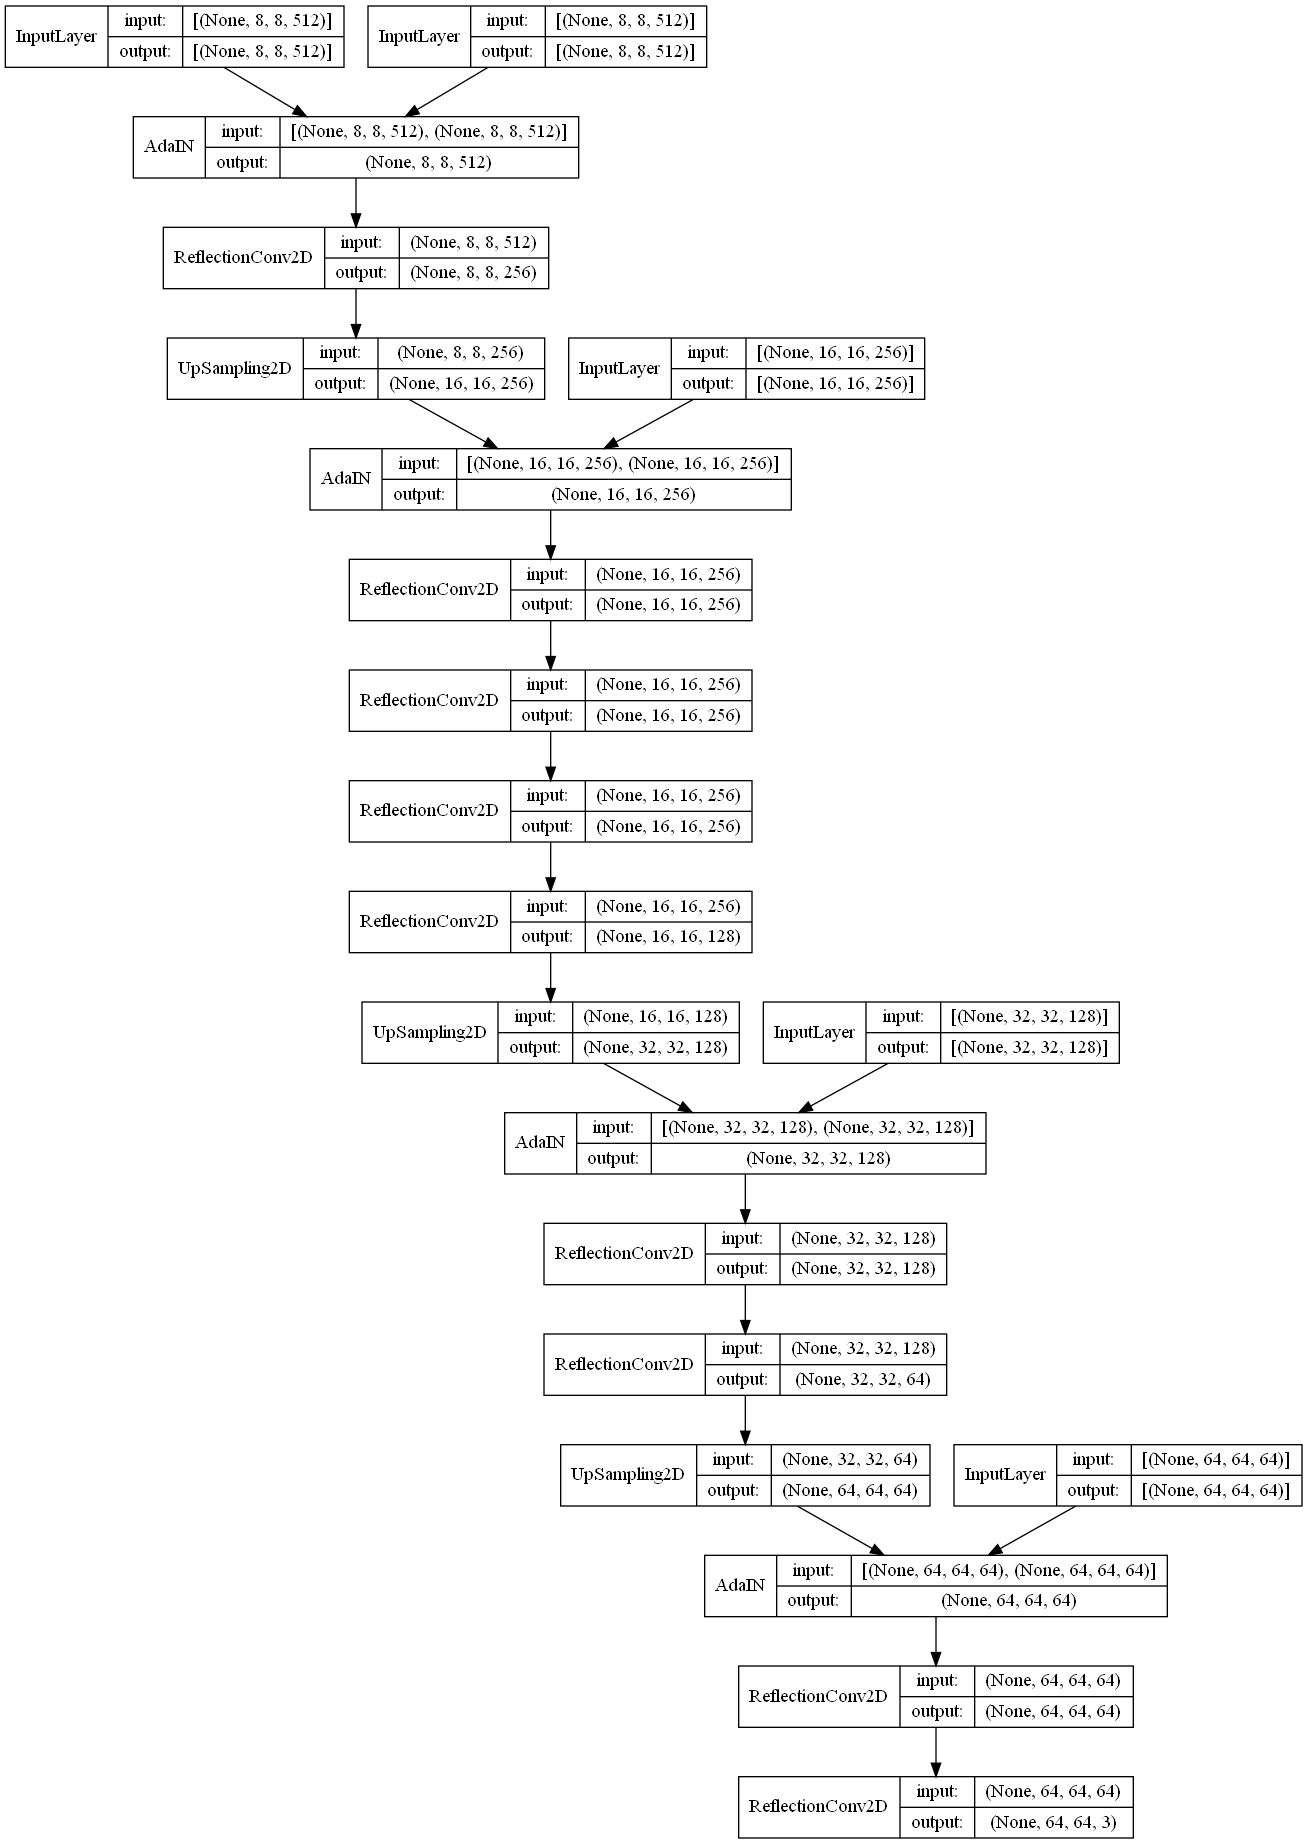

In [73]:
plot_model(decoder_ml_ref, show_shapes=True, show_layer_names=False)

In [74]:
#define a model whose training epoch is divided into discriminator and generator training
class GAN(keras.Model):
    def __init__(self, discriminator,encoder,decoder, inputs):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.inputs = inputs
        self.encoder = encoder
        self.decoder = decoder
        style = self.encoder(self.inputs[1])
        content = self.encoder(self.inputs[0])[-1]
        new_img = self.decoder([content,style])
        self.generator = Model(inputs=self.inputs,outputs={'new_img': new_img, 'content': content},
                               name = 'generator')

    def compile(self, d_optimizer, g_optimizer, loss_style,loss_content,content_weight=10):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_style = loss_style
        self.loss_content = loss_content
        self.content_weight = content_weight
    def train_step(self, img_tuple):
        
        content_img = img_tuple[0]
        style_img = img_tuple[1]
        
        gen_out = self.generator(img_tuple)
        gen_img = gen_out['new_img']
        
        
        # Combine them with real images
        # Assemble labels discriminating real from fake images
        
        
        

        # Train the discriminator
        with tf.GradientTape() as tape_dis:
            predictions_real = self.discriminator(style_img)
            predictions_fake = self.discriminator(gen_img)
            com_img = tf.concat([gen_img, style_img], axis=0)
            com_pred = tf.concat([predictions_real,predictions_fake],axis=0)
            labels = tf.concat(
                            [tf.ones_like(predictions_fake), tf.zeros_like(predictions_real)], axis=0
                            )
            # Add random noise to the labels - important trick!
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
            d_loss = self.loss_style(labels, com_pred)
        grads_dis = tape_dis.gradient(d_loss, self.discriminator.trainable_weights)
        
        
        # Assemble labels that say "all real images"
        with tf.GradientTape() as tape_gen:
            gen_out = self.generator(img_tuple)
            gen_img = gen_out['new_img']
            predictions = self.discriminator(gen_img)
            gen_content = self.encoder(gen_img)[-1]
            misleading_labels = tf.zeros_like(predictions_fake)
            g_loss = self.loss_style(misleading_labels, predictions)
            g_loss += self.content_weight*self.loss_content(gen_content,gen_out['content'])
        grads_gen = tape_gen.gradient(g_loss, self.generator.trainable_weights)
        
        
        
        
        
        self.d_optimizer.apply_gradients(zip(grads_dis, self.discriminator.trainable_weights))
        #upgrade the weights
        self.g_optimizer.apply_gradients(zip(grads_gen, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}
    

In [75]:
#build the complete network:
content_in = layers.Input(shape = (size,size,3))
style_in = layers.Input(shape = (size,size,3))
training_net = GAN(inputs = [content_in,style_in],
                   encoder=encoder_ml_ref,
                   decoder=decoder_ml_ref,
                   discriminator = discriminator_net)
training_net.compile(d_optimizer=tf.keras.optimizers.Adam(),
                     g_optimizer=tf.keras.optimizers.Adam(),
                     loss_style= keras.losses.BinaryCrossentropy(),
                     loss_content = keras.losses.MeanSquaredError(),
                     content_weight = 10000000000)

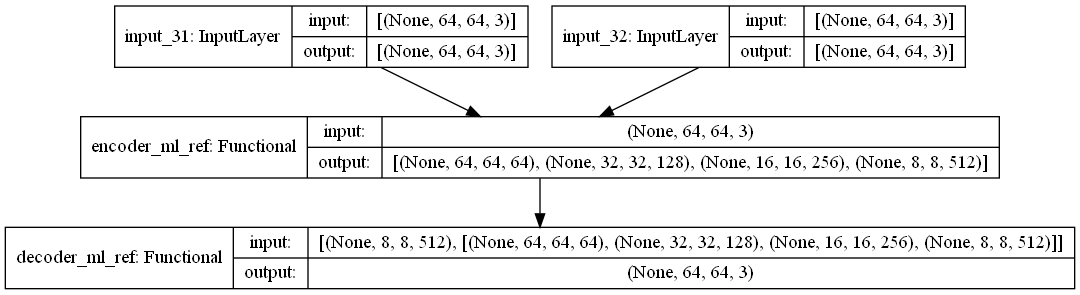

In [76]:
plot_model(training_net.generator, show_shapes=True, show_layer_names=True)

In [77]:
data_base_path = os.path.join(os.pardir, 'Datasets')

pickle_folder = os.path.join('PMID2019', 'pickle_ROI')
pickle_path = os.path.join(data_base_path, pickle_folder)
with open(os.path.join(pickle_path,'crops_dark1.pickle'),'rb') as f:
    dark_ROI = pickle.load(f)
with open(os.path.join(pickle_path,'crops_64_1.pickle'),'rb') as f:
    bright_ROI = pickle.load(f)

In [78]:
def standardize(img,mean=None,var=None,epsilon = 0.0001):
    if mean is None:
        mean = np.mean(img)
    meanless = img-mean
    if var is None:
        var = np.mean(np.square(meanless))
    
    img_n = meanless/(var+epsilon)
    return img_n
def destand(img_n, perc = 1,epsilon = 0.0001):
    pl,ph = np.percentile(img_n, [perc,100-perc])
    img = np.array((img_n-pl)/(epsilon+ph-pl))
    img[img>1]=1
    img[img<0]=0
    return img

In [79]:
#data set creator:
def dataset_gen(bright_ROI=bright_ROI,dark_ROI=dark_ROI):
    n = 0
    np.random.shuffle(bright_ROI)
    np.random.shuffle(dark_ROI)
    while n < min(len(bright_ROI),len(dark_ROI)):
        pair = [standardize(bright_ROI[n].astype(float)),
                standardize(dark_ROI[n].astype(float))]
        np.random.shuffle(pair)
        yield(pair[0],pair[1])
        n+=1

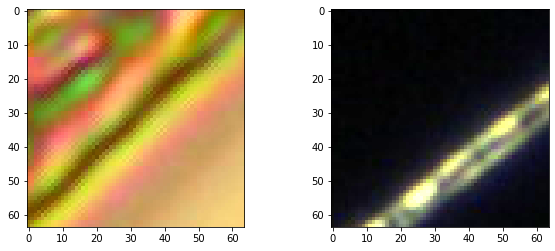

In [80]:
for i,data in enumerate(dataset_gen()):
    if i>0:
        break
    fig, ax = plt.subplots(1,2, figsize=(10, 4))
    ax[0].imshow(destand(data[0]))
    ax[1].imshow(destand(data[1]))
    plt.show()

In [81]:
#datasets for upscalling
batch_size = 16
dataset = tf.data.Dataset.from_generator(dataset_gen,
                                         output_signature =(tf.TensorSpec(shape=(size,size,3), dtype=tf.float32),
                                                            tf.TensorSpec(shape=(size,size,3), dtype=tf.float32)))
dataset = dataset.batch(batch_size)

In [ ]:
history = training_net.fit(x=dataset, epochs=50)

Epoch 1/50
46/46 [==============================] - 20s 338ms/step - d_loss: 0.6695 - g_loss: 937455454948.7660
Epoch 2/50
46/46 [==============================] - 15s 330ms/step - d_loss: 0.1803 - g_loss: 678133594068.4255
Epoch 3/50
46/46 [==============================] - 15s 337ms/step - d_loss: -0.0953 - g_loss: 655385154668.9362
Epoch 4/50
46/46 [==============================] - 16s 348ms/step - d_loss: -0.1272 - g_loss: 696328669576.1702
Epoch 5/50
46/46 [==============================] - 16s 344ms/step - d_loss: -0.1352 - g_loss: 697756404104.1702
Epoch 6/50
46/46 [==============================] - 16s 357ms/step - d_loss: -0.1348 - g_loss: 673478125088.6809
Epoch 7/50
46/46 [==============================] - 16s 350ms/step - d_loss: -0.1305 - g_loss: 660688338246.8085
Epoch 8/50
46/46 [==============================] - 16s 344ms/step - d_loss: -0.1319 - g_loss: 691235464039.4894
Epoch 9/50
24/46 [==============>...............] - ETA: 7s - d_loss: -0.1403 - g_loss: 6817845630

In [ ]:
training_net.generator.load_weights('Model_weights/xxxxxx.h5')


In [ ]:
training_net.generator.compile()

In [ ]:
data = list(dataset.take(1))
out = training_net.generator.predict(data)


In [ ]:
plt.imshow(out['content'][0][:,:,1])
plt.show()
plt.imshow(destand(out['new_img'][0]))

In [ ]:
np.max(out['new_img'])

In [ ]:
def decoder_ml_ref_debug(content,style):
    layer_in = content
    layer_in_s = AdaIN()([layer_in,style[-1]])
    revblock4_conv1 = ReflectionConv2D(256,3,name='revblock4_conv1')(layer_in_s)
    revblock3_pool = layers.UpSampling2D(name='revblock3_pool')(revblock4_conv1)
    revblock3_pool_s = AdaIN()([revblock3_pool,style[-2]])
    revblock3_conv4 = ReflectionConv2D(256,3,name='revblock3_conv4')(revblock3_pool_s)
    revblock3_conv3 = ReflectionConv2D(256,3,name='revblock3_conv3')(revblock3_conv4)
    revblock3_conv2 = ReflectionConv2D(256,3,name='revblock3_conv2')(revblock3_conv3)
    revblock3_conv1 = ReflectionConv2D(128,3,name='revblock3_conv1')(revblock3_conv2)
    revblock2_pool = layers.UpSampling2D(name='revblock2_pool')(revblock3_conv1)
    revblock2_pool_s = AdaIN()([revblock2_pool,style[-3]])    
    revblock2_conv2 = ReflectionConv2D(128,3,name='revblock2_conv2')(revblock2_pool_s)
    revblock2_conv1 = ReflectionConv2D(64,3,name='revblock2_conv1')(revblock2_conv2)
    revblock1_pool = layers.UpSampling2D(name='revblock1_pool')(revblock2_conv1)
    revblock1_pool_s = AdaIN()([revblock1_pool,style[-4]])

    revblock1_conv2 = ReflectionConv2D(64,3,name='revblock1_conv2')(revblock1_pool_s)
    revblock1_conv1 = ReflectionConv2D(3,3,name='revblock1_conv1')(revblock1_conv2)
    m = tf.math.reduce_max(revblock1_conv1)
    return revblock1_conv1,m


style = []

content= layers.Input(shape = encoder_ml_ref.outputs[-1].shape[1:])
for out in encoder_ml_ref.outputs:
    style.append(layers.Input(shape = out.shape[1:]))
img_out,m = decoder_ml_ref_debug(content,style)
decoder_debug = Model(inputs = [content,style],outputs = [img_out,m],name = 'decoder_debug')

In [ ]:
training_net.decoder.compile()

In [ ]:
data = list(dataset.take(1))
enc_cont = training_net.encoder.predict(data[0][0])[-1]
enc_style = training_net.encoder.predict(data[0][1])

In [ ]:
dec_img = training_net.decoder.predict([enc_cont,enc_style])

In [ ]:
plt.imshow(destand(dec_img[1]))

In [28]:
dec_img[1].shape


(64, 64, 3)